In [ ]:

# Cell 1 — Imports + Load Model Utilities

import sys
sys.path.append("..")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from utils.preprocess import add_time_features
from utils.model_utils import load_model, predict_demand

print("Notebook 03 ready — model & utilities imported successfully.")


Enter starting date (YYYY-MM-DD):  2023-11-10
Enter number of days to forecast (e.g., 30, 60, 90):  30



Future Dates Generated:
DatetimeIndex(['2023-11-11', '2023-11-12', '2023-11-13', '2023-11-14',
               '2023-11-15', '2023-11-16', '2023-11-17', '2023-11-18',
               '2023-11-19', '2023-11-20'],
              dtype='datetime64[ns]', freq='D')

Total future days generated: 30


In [ ]:

# Cell 2 — User Input + Generate Future Date Range


def generate_future_dates(start_date, periods=30):
    """
    Generate a list of future dates starting from start_date.

    Parameters:
    - start_date: a starting date (string or datetime)
    - periods: number of future days to forecast
    """
    start_date = pd.to_datetime(start_date)
    future_dates = pd.date_range(start=start_date + pd.Timedelta(days=1), periods=periods)
    return future_dates


# -------- USER INPUT HERE --------
# Example user inputs (these will be replaced by Streamlit later)
user_start_date = input("Enter starting date (YYYY-MM-DD): ")
user_periods = int(input("Enter number of days to forecast (e.g., 30, 60, 90): "))

# Generate the forecast dates
future_dates = generate_future_dates(user_start_date, user_periods)

print("\nFuture Dates Generated:")
print(future_dates[:10])
print(f"\nTotal future days generated: {len(future_dates)}")


Enter store id (e.g., 1–10):  1
Enter item id (e.g., 1–50):  1



Future Feature DataFrame Preview:


,store,item,year,month,dayofweek,month_sin,month_cos
0,1.0,1.0,2023.0,11.0,5.0,-0.5,0.866025
1,1.0,1.0,2023.0,11.0,6.0,-0.5,0.866025
2,1.0,1.0,2023.0,11.0,0.0,-0.5,0.866025
3,1.0,1.0,2023.0,11.0,1.0,-0.5,0.866025
4,1.0,1.0,2023.0,11.0,2.0,-0.5,0.866025


In [ ]:

# Cell 3 — Add Time Features to Future Dates


def create_future_feature_dataframe(future_dates, store, item):
    """
    Convert future dates into the same feature structure used for XGBoost.
    Includes: store, item, year, month, dayofweek, month_sin, month_cos
    """
    
    df = pd.DataFrame({
        "date": future_dates,
        "store": store,   # constant store id
        "item": item      # constant item id
    })

    # Add time-based features
    df = add_time_features(df)

    # Keep only model-required columns
    feature_cols = [
        "store", "item",
        "year", "month", "dayofweek",
        "month_sin", "month_cos"
    ]

    df = df[feature_cols].astype("float32")
    return df


# -------- USER INPUT for store + item (will be replaced by Streamlit later) --------
user_store = int(input("Enter store id (e.g., 1–10): "))
user_item = int(input("Enter item id (e.g., 1–50): "))

# Create future dataframe with time features
future_df = create_future_feature_dataframe(future_dates, user_store, user_item)

print("\nFuture Feature DataFrame Preview:")
future_df.head()


In [ ]:

# Cell 4 — Generate Forecast Using XGBoost


# Load the trained model
model = load_model("../models/xgb_demand_model.json")

# Convert future_df into DMatrix (Booster requires this)
dmatrix_future = xgb.DMatrix(future_df)

# Predict future demand
future_predictions = model.predict(dmatrix_future)

# Round predictions for readability
future_predictions = np.round(future_predictions, 2)

print("\nForecast Preview:")
future_predictions[:10]




Forecast Preview:


array([27.07, 29.54, 18.69, 22.4 , 22.66, 24.41, 25.69, 27.07, 29.54,
       18.69], dtype=float32)

In [ ]:

# Cell 5 — Build Forecast DataFrame


forecast_df = pd.DataFrame({
    "date": future_dates,
    "store": user_store,
    "item": user_item,
    "predicted_sales": future_predictions
})

print("Forecast Table Preview:")
forecast_df.head()


Forecast Table Preview:


,date,store,item,predicted_sales
0,2023-11-11,1,1,27.070000
1,2023-11-12,1,1,29.540001
2,2023-11-13,1,1,18.690001
3,2023-11-14,1,1,22.400000
4,2023-11-15,1,1,22.660000


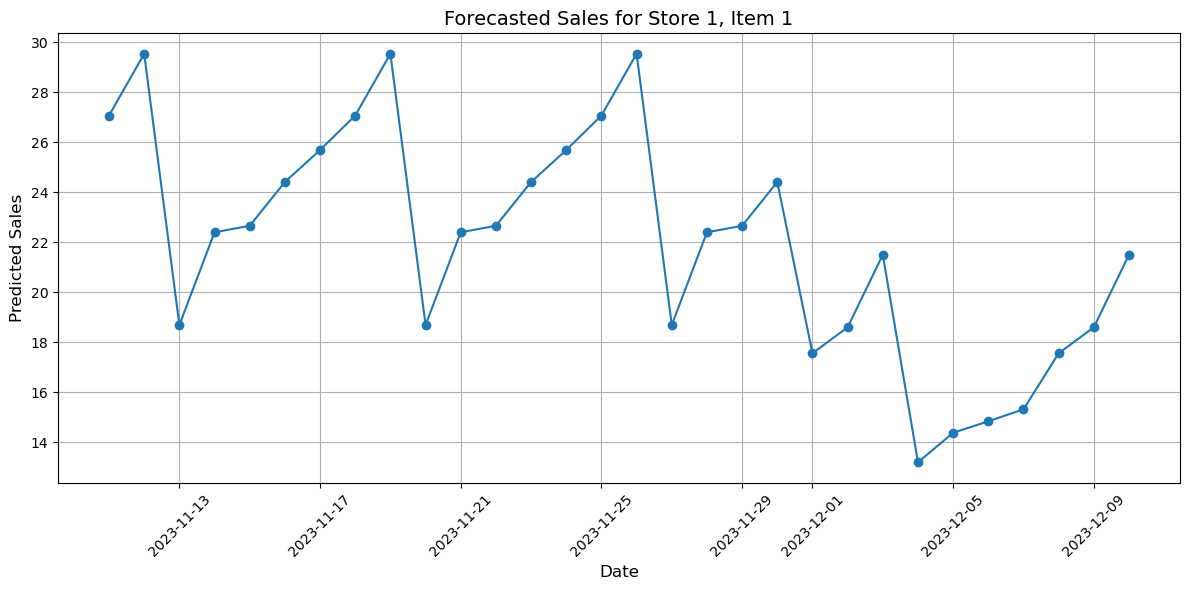

In [ ]:

# Cell 6 — Plot Forecast

plt.figure(figsize=(12, 6))
plt.plot(forecast_df["date"], forecast_df["predicted_sales"], marker="o")

plt.title(f"Forecasted Sales for Store {user_store}, Item {user_item}", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Predicted Sales", fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:

# Cell 7 — Export Forecast as CSV


output_path = f"../datasets/forecast_store{user_store}_item{user_item}.csv"

forecast_df.to_csv(output_path, index=False)

print(f"Forecast CSV saved successfully at: {output_path}")


Forecast CSV saved successfully at: ../datasets/forecast_store1_item1.csv


In [ ]:

# Cell 8 — Build Forecast Summary Table


# Add day name for readability
forecast_df["day_name"] = forecast_df["date"].dt.day_name()

summary_df = forecast_df[[
    "date",
    "day_name",
    "store",
    "item",
    "predicted_sales"
]]

print("Forecast Summary Preview:")
summary_df.head(10)


Forecast Summary Preview:


,date,day_name,store,item,predicted_sales
0,2023-11-11,Saturday,1,1,27.070000
1,2023-11-12,Sunday,1,1,29.540001
2,2023-11-13,Monday,1,1,18.690001
3,2023-11-14,Tuesday,1,1,22.400000
4,2023-11-15,Wednesday,1,1,22.660000
5,2023-11-16,Thursday,1,1,24.410000
6,2023-11-17,Friday,1,1,25.690001
7,2023-11-18,Saturday,1,1,27.070000
8,2023-11-19,Sunday,1,1,29.540001
9,2023-11-20,Monday,1,1,18.690001


In [ ]:

# Cell 9 — End-to-End Forecast Function

def generate_forecast(store, item, start_date, periods=30):
    """
    Full forecasting pipeline:
    - Generate future dates
    - Create features
    - Predict using XGBoost
    - Return a clean forecast dataframe
    """

    # Step 1: Create future dates
    future_dates = generate_future_dates(start_date, periods)

    # Step 2: Create feature dataframe
    future_df = create_future_feature_dataframe(future_dates, store, item)

    # Step 3: Load model
    model = load_model("../models/xgb_demand_model.json")

    # Step 4: Convert to DMatrix + predict
    dmatrix_future = xgb.DMatrix(future_df)
    predictions = model.predict(dmatrix_future)

    # Step 5: Build final output dataframe
    forecast_df = pd.DataFrame({
        "date": future_dates,
        "store": store,
        "item": item,
        "predicted_sales": np.round(predictions, 2)
    })

    forecast_df["day_name"] = forecast_df["date"].dt.day_name()

    return forecast_df


# Test the full pipeline


test_forecast = generate_forecast(
    store=user_store,
    item=user_item,
    start_date=user_start_date,
    periods=user_periods
)

print("Full Forecast Pipeline Test:")
test_forecast.head()


Full Forecast Pipeline Test:


,date,store,item,predicted_sales,day_name
0,2023-11-11,1,1,27.070000,Saturday
1,2023-11-12,1,1,29.540001,Sunday
2,2023-11-13,1,1,18.690001,Monday
3,2023-11-14,1,1,22.400000,Tuesday
4,2023-11-15,1,1,22.660000,Wednesday


In [ ]:

# Cell 10 — Notebook 03 Completion Summary

print("===============================================")
print(" NOTEBOOK 03 — FORECASTING ENGINE COMPLETED")
print("===============================================")

print("\nYour forecasting pipeline is fully ready with:")

print("\n✔ User-controlled start date")
print("✔ User-controlled forecast length (days)")
print("✔ Store + Item selection")
print("✔ Future date generation")
print("✔ Time feature engineering")
print("✔ XGBoost Booster model prediction")
print("✔ Clean forecast output DataFrame")
print("✔ Forecast CSV export")
print("✔ Forecast plot (matplotlib)")

print("\nNext step: Integrate this into Streamlit.")
print("Your Streamlit app will now support:")
print(" - Real-time predictions")
print(" - Full future forecasting")
print(" - CSV download")
print(" - Trend visualization")
print("\nAll systems ready. 🚀")


 NOTEBOOK 03 — FORECASTING ENGINE COMPLETED

Your forecasting pipeline is fully ready with:

✔ User-controlled start date
✔ User-controlled forecast length (days)
✔ Store + Item selection
✔ Future date generation
✔ Time feature engineering
✔ XGBoost Booster model prediction
✔ Clean forecast output DataFrame
✔ Forecast CSV export
✔ Forecast plot (matplotlib)

Next step: Integrate this into Streamlit.
Your Streamlit app will now support:
 - Real-time predictions
 - Full future forecasting
 - CSV download
 - Trend visualization

All systems ready. 🚀


In [14]:
# DATSET PREDICTION
test_df = pd.read_csv("../datasets/main/test.csv", parse_dates=["date"])
test_df.head()


,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [15]:
test_df = add_time_features(test_df)


In [16]:
feature_cols = [
    "store", "item",
    "year", "month",
    "dayofweek",
    "month_sin", "month_cos"
]

X_test_full = test_df[feature_cols].astype("float32")


In [17]:
model = load_model("../models/xgb_demand_model.json")

dmatrix = xgb.DMatrix(X_test_full)

test_predictions = model.predict(dmatrix)
test_predictions = np.round(test_predictions, 2)


In [18]:
test_df["predicted_sales"] = test_predictions
test_df.head()


,id,date,store,item,year,month,day,dayofweek,month_sin,month_cos,predicted_sales
0,0,2018-01-01,1,1,2018,1,1,0,0.5,0.866025,12.01
1,1,2018-01-02,1,1,2018,1,2,1,0.5,0.866025,13.78
2,2,2018-01-03,1,1,2018,1,3,2,0.5,0.866025,13.86
3,3,2018-01-04,1,1,2018,1,4,3,0.5,0.866025,14.32
4,4,2018-01-05,1,1,2018,1,5,4,0.5,0.866025,15.59


In [19]:
test_df.to_csv("../datasets/test_predictions.csv", index=False)
print("Full test predictions exported.")


Full test predictions exported.


In [20]:
# Final submission format (id + predicted_sales)
submission_df = test_df[["id", "predicted_sales"]]

submission_path = "../datasets/submission.csv"
submission_df.to_csv(submission_path, index=False)

print(f"Submission file created at: {submission_path}")
submission_df.head()


Submission file created at: ../datasets/submission.csv


,id,predicted_sales
0,0,12.01
1,1,13.78
2,2,13.86
3,3,14.32
4,4,15.59
